In [1]:
import os
os.environ['TRKXINPUTDIR']="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts"
os.environ['TRKXOUTPUTDIR']= "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest"

In [42]:
%load_ext autoreload
%autoreload 2
import pkg_resources
import yaml
import pprint
import random
random.seed(1234)
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import tqdm
# %matplotlib widget

# 3rd party
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from trackml.dataset import load_event
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint


# local import
# from heptrkx.dataset import event as master
from exatrkx import config_dict # for accessing predefined configuration files
from exatrkx import outdir_dict # for accessing predefined output directories
from exatrkx.src import utils_dir


# for preprocessing
from exatrkx import FeatureStore
from exatrkx.src import utils_torch

# for embedding
from exatrkx import LayerlessEmbedding
from exatrkx.src import utils_torch

# for filtering
from exatrkx import VanillaFilter

# for GNN
import tensorflow as tf
from graph_nets import utils_tf
from exatrkx import SegmentClassifier
import sonnet as snt

# for labeling
from exatrkx.scripts.tracks_from_gnn import prepare as prepare_labeling
from exatrkx.scripts.tracks_from_gnn import clustering as dbscan_clustering

# track efficiency
from trackml.score import _analyze_tracks
from exatrkx.scripts.eval_reco_trkx import make_cmp_plot, pt_configs, eta_configs
from functools import partial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]

In [4]:
import sys
import os
sys.path.append('..')
sys.path.append('/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/')
%matplotlib inline
from utils_robust import *

# Noise 

-----
Data(cell_data=[103305, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[103305], layerless_true_edges=[2, 123429], layers=[103305], pid=[103305], x=[103305, 3])
-----
Data(cell_data=[106831, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[106831], layerless_true_edges=[2, 389588], layers=[106831], pid=[106831], x=[106831, 3])
-----
Data(cell_data=[110358, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[110358], layerless_true_edges=[2, 1146681], layers=[110358], pid=[110358], x=[110358, 3])
-----
Data(cell_data=[113885, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[113885], layerless_true_edges=[2, 2394184], layers=[113885], pid=[113885], x=[113885, 3])
-----
Data(cell_data=[117412, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[117412], layerles

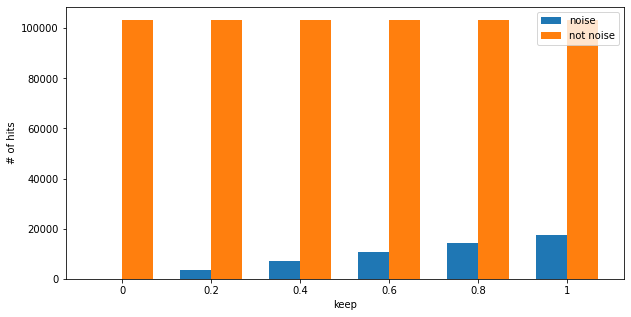

In [5]:
dir_path = "/global/cfs/projectdirs/m3443/usr/caditi97/iml2020"
plot_noise_dist(dir_path, noise_keeps)

# Embedding

In [6]:
# load model
emb_ckpt_path = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
emb_ckpt = torch.load(emb_ckpt_path)

In [7]:
emb_ckpt['hyper_parameters']['train_split'] = [8,1,1]
emb_ckpt['hyper_parameters']['clustering'] = 'build_edges'
emb_ckpt['hyper_parameters']['knn_val'] = 500
emb_ckpt['hyper_parameters']['r_val'] = 1.7
emb_ckpt['hyper_parameters']

"adjacent":       False
"clustering":     build_edges
"emb_dim":        8
"emb_hidden":     512
"endcaps":        True
"factor":         0.3
"in_channels":    12
"input_dir":      /global/cscratch1/sd/danieltm/ExaTrkX/trackml/feature_store_endcaps
"knn":            20
"knn_val":        500
"layerless":      True
"layerwise":      False
"lr":             0.002
"margin":         1
"max_epochs":     100
"nb_layer":       6
"noise":          False
"output_dir":     global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/embedding_processed/0_pt_cut_endcaps
"overwrite":      True
"patience":       5
"project":        EmbeddingStudy
"pt_min":         0
"r_train":        1
"r_val":          1.7
"randomisation":  2
"regime":         ['rp', 'hnm', 'ci']
"train_split":    [8, 1, 1]
"wandb_save_dir": /global/cscratch1/sd/danieltm/ExaTrkX/wandb_data
"warmup":         500
"weight":         4

In [8]:
emb_model = LayerlessEmbedding(emb_ckpt['hyper_parameters'])
emb_model.load_state_dict(emb_ckpt["state_dict"])

<All keys matched successfully>

In [9]:
# best_emb = emb_model.load_from_checkpoint(emb_ckpt_path, hparams=emb_ckpt['hyper_parameters'])

In [10]:
emb_model.eval()

LayerlessEmbedding(
  (layers): ModuleList(
    (0): Linear(in_features=12, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Linear(in_features=512, out_features=512, bias=True)
  )
  (emb_layer): Linear(in_features=512, out_features=8, bias=True)
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (act): Tanh()
)

For one event

In [11]:
embed_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/embedding/checkpoints/epoch=10.ckpt'
filter_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
gnn_ckpt_dir = '/global/cfs/cdirs/m3443/data/lightning_models/gnn'
plots_dir = '/global/homes/c/caditi97/exatrkx-iml2020/exatrkx/src/plots/run1' # needs to change...
ckpt_idx = -1 # which GNN checkpoint to load
dbscan_epsilon, dbscan_minsamples = 0.25, 2 # hyperparameters for DBScan
min_hits = 5 # minimum number of hits associated with a particle to define "reconstructable particles"
frac_reco_matched, frac_truth_matched = 0.5, 0.5 # parameters for track matching

In [12]:
evtid = 1000
event_file = os.path.join(utils_dir.inputdir, 'event{:09}'.format(evtid))

In [13]:
action = 'build'

config_file = pkg_resources.resource_filename(
                    "exatrkx",
                    os.path.join('configs', config_dict[action]))
with open(config_file) as f:
    b_config = yaml.load(f, Loader=yaml.FullLoader)
    
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(b_config)

{   'adjacent': True,
    'cell_information': True,
    'endcaps': True,
    'layerless': True,
    'layerwise': False,
    'n_files': 10,
    'n_tasks': 1,
    'n_workers': 2,
    'noise': 0,
    'pt_min': 0}


In [16]:
b_config['pt_min'] = 0
b_config['endcaps'] = True
b_config['n_workers'] = 1
b_config['n_files'] = 1
b_config['noise'] = 1
b_config

{'adjacent': True,
 'cell_information': True,
 'endcaps': True,
 'layerless': True,
 'layerwise': False,
 'n_files': 1,
 'n_tasks': 1,
 'n_workers': 1,
 'noise': 1,
 'pt_min': 0,
 'input_dir': '/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts',
 'output_dir': '/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/outtest/feature_store'}

In [18]:
data = torch.load('/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out1/feature_store/'+ str(evtid))
data

Data(cell_data=[120939, 9], event_file="/global/cfs/cdirs/m3443/data/trackml-kaggle/train_10evts/event000001000", hid=[120939], layerless_true_edges=[2, 6455778], layers=[120939], pid=[120939], x=[120939, 3])

In [22]:
%%time
spatial = emb_model(torch.cat([data.cell_data, data.x], axis=-1))
spatial.shape

CPU times: user 4.7 s, sys: 1.52 s, total: 6.22 s
Wall time: 3.26 s


torch.Size([120939, 8])

In [24]:
%%time
if(torch.cuda.is_available()):
        spatial = spatial.cuda()

e_spatial = utils_torch.build_edges(spatial, emb_model.hparams['r_val'], emb_model.hparams['knn_val'])
e_spatial.shape

CPU times: user 775 ms, sys: 786 ms, total: 1.56 s
Wall time: 1.82 s


torch.Size([2, 28846659])

In [25]:
e_spatial = e_spatial.cpu().numpy()
e_spatial

array([[     0,      0,      0, ..., 120938, 120938, 120938],
       [  5067,  13626,  39148, ..., 109829, 107002, 107280]])

In [27]:
R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2) # distance away from origin...
R_dist

tensor([0.4232, 0.4100, 0.3287,  ..., 1.5961, 2.6987, 2.7032])

In [28]:
e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]
e_spatial

array([[     0,      0,      0, ..., 120938, 120938, 120938],
       [  5067,  13626,  39148, ..., 120766, 120737, 120714]])

In [33]:
# truth information
e_bidir = torch.cat([data.layerless_true_edges,
                    torch.stack([data.layerless_true_edges[1],
                                data.layerless_true_edges[0]], axis=1).T], axis=-1)
e_bidir.shape

torch.Size([2, 12911556])

In [35]:
e_spatial_n, y_cluster = graph_intersection(torch.from_numpy(e_spatial), e_bidir)

In [36]:
cluster_true = 2*len(data.layerless_true_edges[0])
cluster_true_positive = y_cluster.sum()
cluster_positive = len(e_spatial_n[0])
purity = cluster_true_positive/cluster_positive
purity

0.013091779489700693

In [65]:
def get_emb_metrics(data_path, emb_model):
    data = torch.load(data_path)
    spatial = emb_model(torch.cat([data.cell_data, data.x], axis=-1))
    
    if(torch.cuda.is_available()):
        spatial = spatial.cuda()
        
    e_spatial = utils_torch.build_edges(spatial, emb_model.hparams['r_val'], emb_model.hparams['knn_val'])
    e_spatial_np = e_spatial.cpu().numpy()
    
    # remove R dist from out to in
    R_dist = torch.sqrt(data.x[:,0]**2 + data.x[:,2]**2)
    
    e_spatial_np = e_spatial_np[:, (R_dist[e_spatial_np[0]] <= R_dist[e_spatial_np[1]])]
    e_bidir = torch.cat([data.layerless_true_edges,torch.stack([data.layerless_true_edges[1],
                        data.layerless_true_edges[0]], axis=1).T], axis=-1)
    e_spatial_n, y_cluster = graph_intersection(torch.from_numpy(e_spatial_np), e_bidir)
    
    cluster_true = 2*len(data.layerless_true_edges[0])
    cluster_true_positive = y_cluster.sum()
    cluster_positive = len(e_spatial_n[0])
    purity = cluster_true_positive/cluster_positive
    eff = cluster_true_positive/cluster_true
    
    return purity, eff

In [66]:
p_all = []
e_all = []
for i in noise_keeps:
    data_path = f'/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{i}/feature_store/1000'
    p, e = get_emb_metrics(data_path, emb_model)
    p_all.append(p)
    e_all.append(e)

In [67]:
p_all

[0.011968508575832267,
 0.01135323340351619,
 0.01127674466870048,
 0.011711834057423357,
 0.012268168627049913,
 0.013091779489700693]

In [68]:
e_all

[0.4871950676097189,
 0.1587818413298151,
 0.0579986936209809,
 0.031104125664527037,
 0.020187322314846046,
 0.01480611631936538]

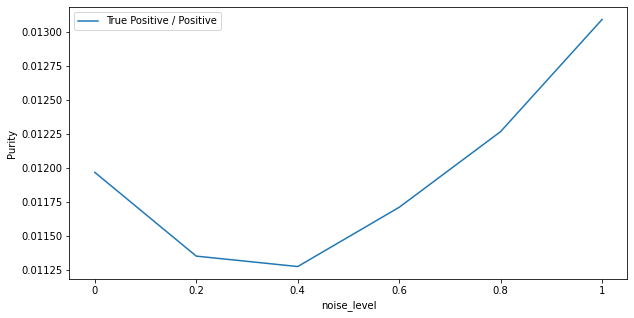

In [71]:
x = np.arange(len(noise_keeps))
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(x, p_all, label = 'True Positive / Positive')
ax1.set_xlabel('noise_level')
ax1.set_ylabel('Purity')
ax1.set_xticks(x)
labels = noise_keeps
ax1.set_xticklabels(labels)
ax1.legend()

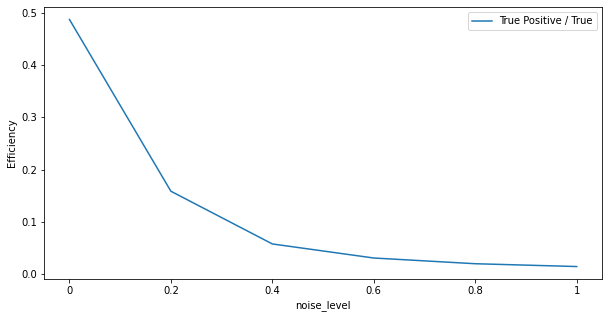

In [72]:
x = np.arange(len(noise_keeps))
fig2, ax2 = plt.subplots(figsize=(10,5))
ax2.plot(x, e_all, label = 'True Positive / True')
ax2.set_xlabel('noise_level')
ax2.set_ylabel('Efficiency')
ax2.set_xticks(x)
labels = noise_keeps
ax2.set_xticklabels(labels)
ax2.legend()

For all events

In [ ]:
# x = np.arange(len(noise_keeps))
# purity = []
# for i in noise_keeps:
#     d_path = f"/global/cfs/projectdirs/m3443/usr/caditi97/iml2020/out{i}/feature_store/1000"
#     data_in = torch.load(d_path)
#     pur = emb_purity(best_emb, data_in)
#     purity.append(pur)

In [ ]:
# fig1, ax1 = plt.subplots(figsize=(10,5))
# ax1.plot(x, purity, label = 'True Hits / All Hits')
# ax1.set_xlabel('noise_level')
# ax1.set_xticks(x)
# labels = noise_keeps
# ax1.set_xticklabels(labels)
# ax1.legend()

# Filtering

In [ ]:
# # load model
# filter_ckpt_path = '/global/cfs/cdirs/m3443/data/lightning_models/filtering/checkpoints/epoch=92.ckpt'
# filter_ckpt = torch.load(filter_ckpt_path)
# filter_model = VanillaFilter(filter_ckpt['hyper_parameters'])
# best_filter = filter_model.load_from_checkpoint(filter_ckpt_path, hparams=filter_ckpt['hyper_parameters'])

In [ ]:
# best_filter.eval()